# Generalized Advantage Estimation (GAE)

지난 장에서는 $n$-step return $G_{t:t+n}$을 타겟값으로 사용하여 가치 네트워크와 정책 네트워크를 학습시켜보았다.
$n$ 값을 어떻게 설정하냐에 따라서 advantage 함수에 대한 추정량의 편향과 분산의 정도가 달라졌다.
$n$이 작을수록 추정량의 분산은 작아지고 편향은 커졌다. 반대로 $n$이 클수록 추정량의 분산이 커지고 편향은 작아졌다.
이 $n$값은 하이퍼파라미터로서 사용자가 튜닝을 통해 최적의 $n$을 찾아야만 한다.

<br>

그렇다면 하나의 $n$값만 사용하지말고 모든 $n$값을 고려하여 advantage 함수의 추정량을 결정하는 것은 어떨까?
모든 $n$값을 exponentially weighted sum하여 advantage 함수를 추정하는 방법을 generalized advantage estimation (GAE) {cite:p}`gae`라고 부른다.
GAE는 TRPO {cite:p}`trpo`, PPO {cite:p}`ppo` 등 유명 알고리즘들을 만드신 John Schulman 박사님의 "[High-Dimensional Continuous Control Using Generalized Advantage Estimation](http://arxiv.org/abs/1506.02438)" 논문에서 소개된 기법이다. 논문에서는 GAE를 TRPO 알고리즘에 적용하긴 하지만 TRPO는 많이 어려운 관계로 우리는 actor-critic 알고리즘에 GAE를 적용해볼 것이다.

<br>

---


## $n$-step return을 이용한 advantage 함수 추정

먼저, $n$-step return $G_{t:t+n}$을 다시 적어보자.

$$G_{t:t+n} = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \cdots + \gamma^{n-1} r_{t+n-1} + \gamma^{n} V_{\phi}(s_{t+n}).$$

<br>

이 값은 policy gradient theorem {eq}`policy-gradient-theorem`에서 행동가치함수 $Q^{\pi}(s_t, a_t)$의 추정치로 사용된다. 한편, advantage 함수의 정의는 행동가치함수에서 상태가치함수를 빼준 것이었다. 즉, 주어진 정책 $\pi$에 대해서 advantage 함수는 다음과 같이 정의된다.

$$A^{\pi}(s,a):= Q^{\pi}(s, a) - V^{\pi}(s), \; \text{for all } \; s \in \mathcal{S} \text{ and } a \in \mathcal{A}.$$

<br>

그럼, $n$-step return에서 슬쩍 $V_{\phi}(s_t)$를 차감해주면 정책 $\pi_\theta$에 대한 $(s_t, a_t)$에서의 advantage 함수의 추정치가 된다. 이를 $\hat{A}_t^{n}$이라고 표기하면 다음과 같이 적어줄 수 있다.

$$\hat{A}_t^n := \textcolor{blue}{G_{t:t+n}} - \textcolor{red}{V_{\phi}(s_t)} =  \textcolor{blue}{r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \cdots + \gamma^{n-1} r_{t+n-1} + \gamma^{n} V_{\phi}(s_{t+n})}  - \textcolor{red}{V_{\phi}(s_t)}.$$

<br>

좋았어. 이제 advantage 함수에 대한 1개의 추정치가 생겼다. 우리는 $n=1$부터 $n=\infty$까지의 $\hat{A}_t^n$를 모두 사용할 것이다. 그러기 위해서는 우리의 환경이 특정 조건에 의해 종료되지 않고 무한히 진행되는 환경임 (infinite horizon이라고 부름)을 가정해야 한다. 그리고 나중에 보겠지만 무한개의 추정치 $\hat{A}_t^n$을 가중합하게 되면 식이 굉장히 예쁘게 정리되기 때문에 실제로 무한개의 $\hat{A}_t^n$을 계산하거나 하진 않는다. 따라서 실제 구현에서는 환경이 infinite horizon이 아니어도 GAE를 사용할 수 있다.

<br>

---

## GAE: $\hat{A}_t^n$의 지수적 가중합 (exponentially weighted sum)

규칙성을 파악하기 위하여 $\hat{A}_t^n$을 $n=1$부터 쭉 적어볼 것이다. 이때 유용하게 사용할 표기 하나를 다음과 같이 정의하도록 하겠다.

$$\delta_t := r_t + \gamma V_{\phi}(s_{t+1}) - V_{\phi}(s_t).$$

<br>

위 식은 $n=1$일 때 advantage 함수 추정치이기도 하며 보통 temporal difference error 줄여서 TD error라고 부른다. 그럼, $\delta_t$ 표기를 사용해서 
$\hat{A}_t^n$을 $n=1$부터 쭉 적어보자. 규칙성이 잘 보이도록 $\textcolor{red}{V_{\phi}(s_t)}$을 맨 앞에 적어주었다. 그리고 표기 편의상 가치 네트워크의 파라미터 표기 $\phi$도 생략했다.

$$
\begin{matrix}
\hat{A}_{t}^{1} &:= &\delta_{t} & = & -V(s_t) + r_{t}+\gamma V(s_{t+1}) \\
\hat{A}_{t}^{2} &:= &\delta_{t} + \gamma \delta_{t+1} & = & -V(s_t) + r_{t} + \gamma r_{t+1} + \gamma^2 V(s_{t+2}) \\
\hat{A}_{t}^{3} &:= &\delta_{t} + \gamma \delta_{t+1} + \gamma^2 \delta_{t+2} & = & -V(s_t) + r_{t} + \gamma r_{t+1} + \gamma^2 r_{t+2} + \gamma^{3} V(s_{t+3}) \\
\vdots & := & \vdots & = & \vdots \\
\hat{A}_{t}^{n} &:= &\sum_{l=0}^{n-1} \gamma^{l} \delta_{t+l} & = & -V(s_t) + r_{t} + \gamma r_{t+1} + \cdots + \gamma^{t+n-1}r_{t+n-1}+\gamma^{t+n} V(s_{t+n}) \\
\end{matrix}
$$

<br>

독자분들께서는 두 번째 등호가 어떻게 성립하는지 유도해보면 좋을 것 같다 (두 번째 열과 세 번째 열이 왜 같은지). 우리는 $\hat{A}_{t}^{n}$을 가중합하여 $(s_t, a_t)$에서의 advantage 함수에 대한 추정치 $\hat{A}_t$로 사용할 것이다. 그리고 $n$이 작을수록 시점 $t$에 가까운 데이터로 구성되어 있기 때문에 이왕이면 큰 가중치를 부여하고 싶다. 특히, return $G_t$를 정의할 때 $t$ 시점에서 멀리 떨어진 보상일수록 할인률 $\gamma$을 계속 곱해주어 미래의 보상에 대한 가중치를 낮춰준 것처럼 지수적 가중합을 사용할 것이다. 따라서 새로운 하이퍼파라미터 $\lambda \in [0, 1]$를 도입하여 $\hat{A}_{t}^{n}$을 지수적 가중합을 해줄 것이다. 즉,

$$
\hat{A}_t :=  (1-\lambda)\left( \hat{A}_t^{1} + \lambda \hat{A}_t^{2} + \lambda^2 \hat{A}_t^{3} + \ldots \right),
$$

<br>

여기서 괄호 안은 $\hat{A}_{t}^{n}$을 지수적 가중합해준 것이다. 맨 앞의 $1-\lambda$를 곱해준 이유는 나중에 밝혀진다. 위 식을 쭉 정리해보자.

$$
\begin{matrix}
\hat{A}_t & := & (1-\lambda)\left( \hat{A}_t^{(1)} + \lambda \hat{A}_t^{(2)} + \lambda^2 \hat{A}_t^{(3)} + \ldots \right) \\
& = & (1-\lambda) \left( 
\delta_t +\lambda\left(\delta_t + \gamma \delta_{t+1}\right) + \lambda^2 \left(\delta_t + \gamma \delta_{t+1} + \gamma^2 \delta_{t+2} \right)
+\ldots
\right) \\
& = & (1-\lambda) \left( \left(1+\lambda+\lambda^2+\ldots\right)\delta_t + \gamma \lambda \left(1 +\lambda+\lambda^2+\ldots\right)\delta_{t+1} + \gamma^2 \lambda^2 \left(1 +\lambda+\lambda^2+\ldots\right)\delta_{t+2} + \ldots \right) \\
& = & 
\left( \delta_t + \gamma \lambda \delta_{t+1} + \gamma^2 \lambda^2 \delta_{t+2} + \ldots \right) \\
& = & \sum_{l=0}^{\infty} (\gamma\lambda)^l \delta_{t+l}
\end{matrix}
$$

<br>

두 번째 등호의 우변은 각 $\hat{A}_{t}^{n}$들을 $\delta_t$텀들을 사용하여 적어준 것이고, 세 번째 등호는 그냥 $\delta_t$끼리 모아서 정리한 것이다. 네 번째 등호는 기하급수 공식인 $\sum_{k=1}^{\infty} r^{k-1} = \frac{1}{1-r}$을 사용해준 것이다. 여기서 분모를 없애주기 위하여 맨 앞의 $1-\lambda$가 있었던 것이다. 마지막 등호를 통해 GAE $\hat{A}_t$는 각 시점 $t$에서의 TD error $\delta_t=r_t + \gamma V_{\phi}(s_{t+1}) - V_{\phi}(s_t)$를 지수적 가중합한 것임을 알 수 있다. 미래의 TD error일수록 $\gamma \lambda$를 곱해주어 가중치를 낮춰준 것이다. 따라서 우리는 모든 $n$-step return을 구할 필요가 없이 각 transition $(s_t, a_t, r_t, s_{t+1})$을 사용하여 $\delta_t$를 계산해주고, 이들을 가중합하여 GAE를 계산할 수 있는 것이다. 물론, 실제 구현에서는 무한개를 다 더해줄 수 없기 때문에 정해진 횟수만큼만 더해주게 된다.

<br>

---

## GAE actor-critic 구현

이번 장에서는 GAE를 사용한 actor-critic 알고리즘을 `Pendulum-v1` 환경에 적용해볼 것이다. Buffer로 그냥 리스트를 사용해도 상관 없지만 이왕이면 지난 $n$-step actorc-critic 구현에서 만든 `RolloutBuffer()`를 사용해볼 것이다. 먼저 필요한 패키지들을 불러오자

In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

from collections import deque
from torch.distributions import Normal
from tqdm import tqdm

<br>

### GAEActorCritic 클래스 구현

GAE 구현은 BatchActorCritic() 클래스에서 `__init__()` 메서드와 `learn()` 메서드만 수정해주면 된다. 먼저, `__init__()` 메서드에는 GAE 계산에 필요한 하이퍼파라미터인 $\lambda$만 추가해주면 된다. $\lambda$ 값으로는 0.95를 제일 많이 사용한다.

~~~python
class GAEActorCritic:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dims=(512, ),
        batch_size=32,
        activation_fn=F.relu,
        policy_lr=0.0003,
        value_lr=0.0003,
        gamma=0.99,
        lmda=0.95
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.value = MLPStateValue(state_dim, hidden_dims, activation_fn).to(self.device)        
        self.gamma = gamma
        self.lmda = lmda
        self.batch_size = batch_size

        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=value_lr)
        
        self.buffer = RolloutBuffer()
~~~

<br>

다음으로 `learn()` 메서드이다. 타겟값을 계산하는 부분을 GAE로 바꿔주면 되며, REINFORCE에서 return $G_t$를 구하는 과정과 유사하게 구현된다. 그리고 GAE 논문에서는 가치 네트워크를 업데이트할 때 REINFORCE with baseline처럼 return $G_t$를 타겟값으로 사용한다. 

~~~python
    def learn(self):
        self.policy.train()
        self.value.train()
        s, a, r, s_prime, done = self.buffer.sample()
        s, a, r, s_prime, done = map(lambda x: x.to(self.device), [s, a, r, s_prime, done])
        
        # GAE 계산
        with torch.no_grad():
            delta = r + (1 - done) * self.gamma * self.value(s_prime) - self.value(s)  # \delta_t 담은 배열
            adv = torch.clone(delta)  # gae를 담을 배열
            ret = torch.clone(r) # return을 담을 배열
            for t in reversed(range(len(r) - 1)):
                adv[t] += (1 - done[t]) * self.gamma * self.lmda * adv[t + 1]
                ret[t] += (1 - done[t]) * self.gamma * ret[t + 1]

        # \pi(a|s) 로그 확률 값 계산하기
        mu, std = self.policy(s)
        m = Normal(mu, std)
        z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
        log_probs = m.log_prob(z)
        
        # 가치 네트워크 업데이트하기
        value = self.value(s)
        value_loss = F.mse_loss(value, ret)
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        # 정책 네트워크 업데이트
        policy_loss = -(log_probs * adv).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        result = {'policy_loss': policy_loss.item(), 'value_loss': value_loss.item()}

        return result
~~~

<br>

이렇게만 변동 사항이 있고 나머지 코드는 이전 actor-critic 알고리즘들 구현과 동일하다. 코드를 쭉 나열하도록 하겠다.

In [2]:
class RolloutBuffer:
    def __init__(self):
        self.buffer = list()

    def store(self, transition):
        self.buffer.append(transition)

    def sample(self):
        s, a, r, s_prime, done = map(np.array, zip(*self.buffer))
        self.buffer.clear()
        return (
            torch.FloatTensor(s),
            torch.FloatTensor(a),
            torch.FloatTensor(r).unsqueeze(1),
            torch.FloatTensor(s_prime),
            torch.FloatTensor(done).unsqueeze(1)
        )

    @property
    def size(self):
        return len(self.buffer)

<br>



### 정책 네트워크 및 상태 가치 네트워크 구현


In [3]:
class MLPGaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPGaussianPolicy, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.mu_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.log_std_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))

        mu = self.mu_layer(x)
        log_std = torch.tanh(self.log_std_layer(x))

        return mu, log_std.exp()


class MLPStateValue(nn.Module):
    def __init__(self, state_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPStateValue, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))
        x = self.output_layer(x)

        return x

<br>

### GAE actor-critic 에이전트 구현

In [4]:
class GAEActorCritic:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dims=(512, ),
        batch_size=32,
        activation_fn=F.relu,
        policy_lr=0.0003,
        value_lr=0.0003,
        gamma=0.99,
        lmda=0.95
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.value = MLPStateValue(state_dim, hidden_dims, activation_fn).to(self.device)        
        self.gamma = gamma
        self.lmda = lmda
        self.batch_size = batch_size

        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=value_lr)
        
        self.buffer = RolloutBuffer()

    @torch.no_grad()
    def act(self, s, training=True):
        self.policy.train(training)

        s = torch.as_tensor(s, dtype=torch.float, device=self.device)
        mu, std = self.policy(s)
        z = torch.normal(mu, std) if training else mu
        action = torch.tanh(z)

        return action.cpu().numpy()
    
    def learn(self):
        self.policy.train()
        self.value.train()
        s, a, r, s_prime, done = self.buffer.sample()
        s, a, r, s_prime, done = map(lambda x: x.to(self.device), [s, a, r, s_prime, done])
        
        # GAE 계산
        with torch.no_grad():
            delta = r + (1 - done) * self.gamma * self.value(s_prime) - self.value(s)  # \delta_t 담은 배열
            adv = torch.clone(delta)  # gae를 담을 배열
            ret = torch.clone(r) # return을 담을 배열
            for t in reversed(range(len(r) - 1)):
                adv[t] += (1 - done[t]) * self.gamma * self.lmda * adv[t + 1]
                ret[t] += (1 - done[t]) * self.gamma * ret[t + 1]

        # \pi(a|s) 로그 확률 값 계산하기
        mu, std = self.policy(s)
        m = Normal(mu, std)
        z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
        log_probs = m.log_prob(z).sum(dim=-1, keepdim=True)
        
        # 가치 네트워크 업데이트하기
        value = self.value(s)
        value_loss = F.mse_loss(value, ret)
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        # 정책 네트워크 업데이트
        policy_loss = -(log_probs * adv).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        result = {'policy_loss': policy_loss.item(), 'value_loss': value_loss.item()}

        return result
    
    def step(self, transition):
        result = None
        self.buffer.store(transition)
        if self.buffer.size >= self.batch_size:
            result = self.learn()

        return result
        

<br>

___

### GAE actor-critic 에이전트 훈련

In [5]:
def evaluate(env_name, agent, seed, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for i in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=seed + 100 + i), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

In [6]:
def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


In [7]:
env_name = 'Pendulum-v1'

seed = 1
seed_all(seed)
hidden_dims = (64, 64, )
max_iterations = 1000000
eval_intervals = 10000
eval_iterations = 10
batch_size = 64
activation_fn = torch.tanh
gamma = 0.90
lmda = 0.7

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = GAEActorCritic(
    state_dim,
    action_dim,
    hidden_dims=hidden_dims,
    activation_fn=activation_fn,
    batch_size=batch_size,
    gamma=gamma,
    lmda=lmda
)

logger = []
(s, _), terminated, truncated = env.reset(seed=seed), False, False
for t in tqdm(range(1, max_iterations + 1)):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
    result = agent.step((s, a, r, s_prime, terminated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, seed, eval_iterations)
        logger.append([t, 'Avg return', score])

100%|██████████| 1000000/1000000 [09:20<00:00, 1785.20it/s]


<br>

아래는 결과 학습 곡선이다.

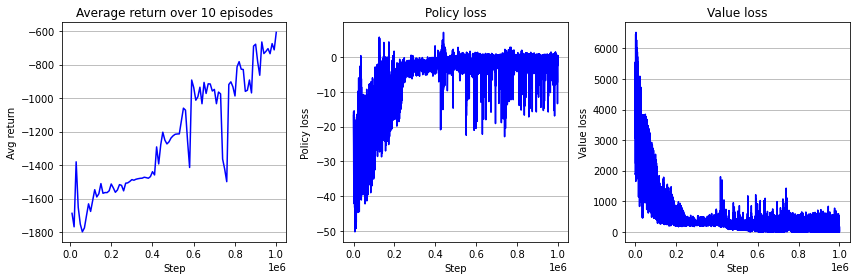

In [8]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 3, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 3, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(1, 3, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

fig.tight_layout()
plt.show()

오늘 구현한 GAE를 이용하는 actor-critic 알고리즘은 이론을 구현해보는 데 초점을 맞추느라 상대적으로 쉬운 actor-critic에 필자가 GAE만 추가한 것 뿐이며 실제로는 사용되지 않는다. 하지만, 오늘 구현한 코드에서 조금만 수정하면 그 유명한 PPO 알고리즘이 된다. 하지만 PPO까지 가기 위해서는 TRPO 알고리즘을 알아야 하는데 그 이론이 조금 빡세다. 그리고 TRPO, GAE, PPO 알고리즘들은 코드 구현에 사소한 추가 디테일들이 있어야만 성능이 잘 나올 수 있다. 아직은 코드 구현 디테일에 대해서는 다루지 않았으며, 이후 PPO 알고리즘에서 알아볼 예정이다. 

<br>


```{raw} html
<script
   type="text/javascript"
   src="https://utteranc.es/client.js"
   async="async"
   repo="HiddenBeginner/Deep-Reinforcement-Learnings"
   issue-term="pathname"
   theme="github-light"
   label="💬 comment"
   crossorigin="anonymous"
/>
```